#### Load packages

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import ast

### First Phase (5 agents, 3 balls fixed)

#### Perfect communication model in BSM

In [2]:
class Agent():
    def __init__(self, model, id, reliability):
        self.model = model
        self.id = id
        self.r = reliability
        self.peers = [] # list of all scientists
        self.urn = np.array([]) # probability [nature, agent 1, agent 2,...]
        self.belief = 0 # current belief
        self.choice = None
        self.n_success = 0 # accumulted number of successes
    def choose(self):
        """randomly draw one ball"""
        prob = self.urn/sum(self.urn)
        return np.random.choice(len(self.urn), size=1, p=prob)[0]
    def experiment(self):
        """consult nature, chance of success = reliability"""
        return 1 if random.random() < self.r else 0
    def update(self):
        """update belief based on choice"""
        self.choice = int(self.choose())
        if self.choice == 0:
            self.belief = self.experiment()
        else:
            self.belief = self.peers[self.choice - 1].belief
        self.n_success += self.belief
    def reinforce(self):
        if self.belief:
            self.urn[self.choice] += 1

In [3]:
class Model():
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200):
        """n: total number of agents"""
        self.n = n
        self.round_per_gen = round_per_gen
        self.gen_per_run = gen_per_run
        self.agents = [] # list of agents
        self.Rs = [round(random.random(), 2) for i in range(n)] # varying reliability
        """create agents"""
        for i in range(n):
            self.agents.append(Agent(self, i, self.Rs[i]))
        self.init_agents()
    def init_agents(self):
        """update agent parameters"""
        for a in self.agents:
            a.peers = self.agents
            a.urn = np.array([1] * (self.n + 1))
            a.urn[a.id+1] = 0
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls) # Agents update in random order
        for i in ls:
            a = self.agents[i]
            a.update()
            a.reinforce()
    def run(self):
        for i in range(self.gen_per_run):
            for a in self.agents:
                a.belief = a.experiment() # Initiate agent beliefs by consulting nature
            for i in range(self.round_per_gen):
                self.play()

#### Draw network

In [4]:
def create_network(model, threshold):    
    
    # Create a directed graph with significant edges (above threshold prob)
    G = nx.DiGraph()
    G.add_node('nature')
    for a in model.agents:
        G.add_node(a.id)
        if a.urn[0]/sum(a.urn) > threshold:
            G.add_edge(a.id, "nature", weight=a.urn[0]/sum(a.urn))
        for i in range(model.n):
            if (a.id != i) and (a.urn[i+1]/sum(a.urn) > threshold):
                G.add_edge(a.id, i, weight=a.urn[i+1]/sum(a.urn))
    return(G)

In [5]:
def plot_network(model, G=None, threshold=0.3):

    if G == None:
        G = create_network(model, threshold)
    # Get the weights for the edges
    weights = nx.get_edge_attributes(G, 'weight')
    
    # Normalize weights for better visualization
    max_weight = max(weights.values(), default=1)
    edge_widths = [(weight * 2) / max_weight for weight in weights.values()]
    
    # Draw the network
    pos = nx.shell_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=1500, 
            arrows=True, arrowstyle='-|>', arrowsize=20, edge_color='black', 
            width=edge_widths, edgecolors='black')

    # Label with reliability
    labels = {key: value for key, value in zip(range(model.n), model.Rs)}
    labels['nature'] = 'nature'
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    # Label edges
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}

    for (u, v), label in edge_labels.items():
        # Compute midpoint
        x_start, y_start = pos[u]
        x_end, y_end = pos[v]
        
        # Offset to position label closer to the start of the edge
        offset = 0.6  # Adjust this value to control the distance from the start
        x_label = x_start + offset * (x_end - x_start)
        y_label = y_start + offset * (y_end - y_start)
        
        # Draw the label
        plt.text(x_label, y_label, label, color='black', fontsize=10, 
                 ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')
                )

#### Test Model Code

In [6]:
df = pd.DataFrame(columns=['reliability', 'matrix', 'success'])
for i in range(1):
    m = Model(n=5)
    m.run()
    df.loc[i] = [m.Rs, [a.urn for a in m.agents], [a.n_success for a in m.agents]]

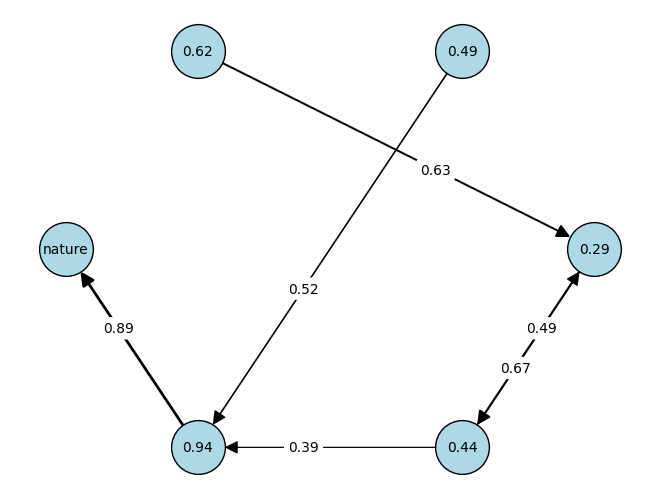

In [7]:
plot_network(m)

In [8]:
df

,reliability,matrix,success
0,"[0.94, 0.44, 0.49, 0.29, 0.62]","[[16530, 0, 199, 337, 1048, 525], [413, 6740, ...","[18634, 17448, 17763, 17417, 17390]"


#### BH Model (My Version)

In [63]:
class BHAgent(Agent):
    def __init__(self, model, id, reliability, n_votes=3):
        super().__init__(model, id, reliability)
        self.n_votes = n_votes
        self.results = None
    def choose(self):
        choice = np.array([0]*len(self.urn)) # Array recording balls drawn
        for i in range(self.n_votes):
            prob = self.urn/sum(self.urn) # Prob proportionate to num of balls
            pick = np.random.choice(range(len(self.urn)), p=prob)
            choice[pick] += 1
            self.urn[pick] -= 1
        self.urn = self.urn + choice # Return balls back to urn
        return choice
    def update(self):
        """update belief by majority vote"""
        self.choice = self.choose()
        ex_results = np.array([sum([self.experiment() for i in range(self.choice[0])])])
        peer_results = self.choice[1:] * np.array([a.belief for a in self.model.agents])
        self.results = np.concatenate((ex_results, peer_results), axis=0)
        votes = sum(self.results)
        if votes > (sum(self.choice) * 0.5):
            self.belief = 1
        elif votes < (sum(self.choice) * 0.5):
            self.belief = 0
        else:
            self.belief = random.choice([0, 1])
        self.n_success += self.belief
    def reinforce(self):
        if self.belief:
            self.urn = self.urn + self.choice

In [64]:
class BHModel(Model):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200):
        """n: total number of agents"""
        super().__init__(n, round_per_gen, gen_per_run)
        self.agents = []
        for i in range(n):
            self.agents.append(BHAgent(self, i, self.Rs[i]))
        self.init_agents()

#### Add Group Reward (Consensus) to BH Model

In [24]:
class CoopWeightAgent(BHAgent):
    "Strength of reinforcement dependent on success of group"
    "Only reinforce if there is individual success"
    def __init__(self, model, id, reliability, n_votes=3, w=1):
        super().__init__(model, id, reliability, n_votes)
        self.w = w # weight
    def reinforce(self, s):
        if self.belief:
            self.urn = self.urn + self.choice * self.w * s

In [25]:
class CoopBonusAgent(BHAgent):
    "First reinforce based on individual results"
    "BONUS reinforcement dependent on success of group"
    def __init__(self, model, id, reliability, n_votes=3, w=1):
        super().__init__(model, id, reliability, n_votes)
        self.w = w # weight
    def reinforce(self, s):
        if self.belief:
            self.urn = self.urn + self.choice
        self.urn = self.urn + self.choice * self.w * s # group reinforcement regardless of belief

In [26]:
class CoopRewardModel(BHModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1, v=1):
        super().__init__(n, round_per_gen, gen_per_run)
        self.w = weight
        self.agents = []
        if v == 1:
            for i in range(n):
                self.agents.append(CoopWeightAgent(self, i, self.Rs[i]))
        elif v == 2:
            for i in range(n):
                self.agents.append(CoopBonusAgent(self, i, self.Rs[i]))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = sum([a.belief for a in self.agents]) # Number of successful agents this round
        for a in self.agents:
            a.reinforce(s)

#### Add Competition to BH Model

In [27]:
class CompetitionModel(BHModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1, v=1):
        super().__init__(n, round_per_gen, gen_per_run)
        self.w = weight
        self.agents = []
        if v == 1:
            for i in range(n):
                self.agents.append(CoopWeightAgent(self, i, self.Rs[i]))
        elif v == 2:
            for i in range(n):
                self.agents.append(CoopBonusAgent(self, i, self.Rs[i]))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = self.n - sum([a.belief for a in self.agents]) # Number of unsuccessful agents this round
        for a in self.agents:
            a.reinforce(s)

#### Compare Binary Models

In [67]:
columns = ['reliability', 
           'matrix_BSM', 'success_BSM',
           'matrix_BH', 'success_BH', 
           'matrix_CoopWeight_F', 'success_CoopWeight_F',
           'matrix_CompWeight_F', 'success_CompWeight_F'
          ]
df = pd.DataFrame(columns=columns)
n = 5

Rs = pd.read_csv('Rs.csv')
Rs = Rs['reliability'].apply(ast.literal_eval)

for i in range(1):
    models = [Model(n=n),
              BHModel(n=n),
              CoopRewardModel(n=n, weight=1), 
              CompetitionModel(n=n, weight=1)]
    for m in models:
        for a in m.agents:
            a.r = Rs[i][a.id]
    data = []
    data.append(Rs[i])
    for m in models:
        m.run()
        data.append([a.urn for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

In [68]:
df

,reliability,matrix_BSM,success_BSM,matrix_BH,success_BH,matrix_CoopWeight_F,success_CoopWeight_F,matrix_CompWeight_F,success_CompWeight_F
0,"[0.69, 0.78, 0.62, 0.07, 0.99]","[[1115, 0, 5117, 146, 3250, 9052], [1099, 3788...","[18675, 18610, 18590, 19047, 19456]","[[14887, 0, 21719, 11390, 4610, 3871], [9454, ...","[18824, 19135, 18687, 19059, 19604]","[[9777, 0, 3754, 21997, 1163, 198118], [40487,...","[15821, 15936, 15875, 15529, 15821]","[[18803, 0, 3878, 1687, 3978, 2484], [7831, 40...","[16204, 16913, 14214, 14823, 17410]"


#### Test Baseline

In [14]:
columns = ['matrix_BH', 'success_BH', 
           'matrix_CoopWeight', 'success_CoopWeight', 
           'matrix_CompWeight', 'success_CompWeight']
df = pd.DataFrame(columns=columns)
n = 5

for i in range(1):
    models = [BHModel(n=n), 
              CoopRewardModel(n=n, weight=1, v=1),
              CompetitionModel(n=n, weight=1, v=1)]
    for m in models:
        for a in m.agents:
            a.r = 0.5
    data = []
    for m in models:
        m.run()
        data.append([a.urn for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

df

,matrix_BH,success_BH,matrix_CoopWeight,success_CoopWeight,matrix_CompWeight,success_CompWeight
0,"[[8573, 0, 2718, 6422, 7388, 4904], [5590, 108...","[10000, 10018, 10041, 10035, 9958]","[[58020, 0, 15442, 1671, 3598, 34524], [69320,...","[9928, 9833, 9890, 9883, 9936]","[[5526, 0, 17899, 2745, 842, 13646], [14372, 1...","[10002, 10074, 10064, 10005, 10048]"


### Fine-grained reward

In [75]:
class fgBHAgent(BHAgent):
    def __init__(self, model, id, reliability, n_votes=3):
        super().__init__(model, id, reliability)
        self.n_votes = n_votes
    def reinforce(self):
        """Only reinforce for agents that gave the correct answer this round""" 
        """(Instead of everyone asked this round)"""
        if self.belief:
            self.urn = self.urn + self.results

In [76]:
class fgBHModel(BHModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200):
        """n: total number of agents"""
        super().__init__(n, round_per_gen, gen_per_run)
        self.agents = []
        for i in range(n):
            self.agents.append(fgBHAgent(self, i, self.Rs[i]))
        self.init_agents()

In [77]:
class fgCoopWeightAgent(CoopWeightAgent):
    "Strength of reinforcement dependent on success of group"
    "Only reinforce if there is individual success"
    def __init__(self, model, id, reliability, n_votes=3, w=1):
        super().__init__(model, id, reliability, n_votes, w)
    def reinforce(self, s):
        """Only reinforce for agents that gave the correct answer this round""" 
        """(Instead of everyone asked this round)"""
        if self.belief:
            self.urn = self.urn + self.results * self.w * s

In [81]:
class fgCoopRewardModel(CoopRewardModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1):
        super().__init__(n, round_per_gen, gen_per_run, weight)
        self.agents = []
        for i in range(n):
            self.agents.append(fgCoopWeightAgent(self, i, self.Rs[i]))
        self.init_agents()

In [82]:
class fgCompetitionModel(fgCoopRewardModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1):
        super().__init__(n, round_per_gen, gen_per_run, weight)
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = self.n - sum([a.belief for a in self.agents]) # Number of unsuccessful agents this round
        for a in self.agents:
            a.reinforce(s)

#### Test fine-grained reward models

In [83]:
columns = ['reliability', 
           'matrix_BSM', 'success_BSM',
           'matrix_fgBH', 'success_fgBH', 
           'matrix_fgCoopWeight_F', 'success_fgCoopWeight_F',
           'matrix_fgCompWeight_F', 'success_fgCompWeight_F'
          ]
df = pd.DataFrame(columns=columns)
n = 5

Rs = pd.read_csv('Rs.csv')
Rs = Rs['reliability'].apply(ast.literal_eval)

for i in range(1):
    models = [Model(n=n),
              fgBHModel(n=n),
              fgCoopRewardModel(n=n, weight=1), 
              fgCompetitionModel(n=n, weight=1)]
    for m in models:
        for a in m.agents:
            a.r = Rs[i][a.id]
    data = []
    data.append(Rs[i])
    for m in models:
        m.run()
        data.append([a.urn for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

In [84]:
df

,reliability,matrix_BSM,success_BSM,matrix_BH,success_BH,matrix_CoopWeight_F,success_CoopWeight_F,matrix_CompWeight_F,success_CompWeight_F
0,"[0.69, 0.78, 0.62, 0.07, 0.99]","[[304, 0, 5764, 5231, 3313, 3104], [2455, 1707...","[17711, 17614, 17714, 17648, 18339]","[[522, 0, 16640, 8354, 16835, 12110], [112, 72...","[18284, 18337, 18259, 18250, 18514]","[[358, 0, 62303, 138008, 1609, 3956], [13788, ...","[14313, 14337, 14305, 14364, 14619]","[[39, 0, 5, 11, 1, 606], [42, 22, 0, 111, 8, 3...","[19914, 19933, 19878, 19929, 19986]"
